# LSTM for stock prediction

## Import Library

In [ ]:
!sudo pip install torch==2.0.0 pandas numpy tqdm matplotlib

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

from typing import Any, Dict, List, Tuple

import os
import csv

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Constants Definition

In [59]:
EXTENDED_FEATURES = [
]
NORMALIZED_FEATURE = [
    'imbalance_size',
    'matched_size',
    'bid_size',
    'ask_size'
]
FILL_ONE_FEATURES = [
    "reference_price", 
    "far_price",
    "near_price",
    "bid_price",
    "ask_price",
    "wap"
]
FILL_MEAN_FEATURES = [
    "imbalance_size", 
    "matched_size"
]
MODEL_INPUT_FEATURES = [
    'imbalance_size', 
    'imbalance_buy_sell_flag',
    'reference_price',
    'matched_size',
    'far_price',
    'near_price',
    'bid_price',
    'bid_size',
    'ask_price',
    'ask_size',
    'wap',
    'target'
]

## Hyper Parameters

In [105]:
BATCH_SIZE: int = 256
EPOCHS: int = 300
LEARNING_RATE: float = 0.00001

## Import Dataset

In [61]:
kaggle_dir = './kaggle'
df = pd.read_csv(os.path.join(kaggle_dir, 'train.csv'))
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [6]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [7]:
def inspect_columns(df):

    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

inspect_columns(df)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0,181,199,int64
date_id,False,481,False,0.00,0,27,480,int64
seconds_in_bucket,False,55,False,0.00,0,410,540,int64
imbalance_size,False,2971863,True,0.00,3180602.69,2400918.36,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0.00,1,-1,-1,int64
reference_price,False,28741,True,0.00,0.999812,0.997309,1.002129,float64
matched_size,False,2948862,True,0.00,13380276.64,9135345.31,24073677.32,float64
far_price,False,95739,True,55.26,NaN,0.898997,1.000859,float64
near_price,False,84625,True,54.55,NaN,0.979654,1.001494,float64
bid_price,False,28313,True,0.00,0.999812,0.997309,1.002129,float64


## Data Splitting

In [62]:
train_df: pd.DataFrame = df.loc[(0 <= df['date_id']) & (df['date_id'] <= 399)]
valid_df: pd.DataFrame = df.loc[(400 <= df['date_id']) & (df['date_id'] <= 477)]
test_df: pd.DataFrame = df.loc[((477 == df['date_id']) & (500 <= df['seconds_in_bucket'])) | ((478 <= df['date_id']) & (df['date_id'] <= 480))]

print(f'The shape of train_df = {train_df.shape}')
print(f'The shape of valid_df = {valid_df.shape}')
print(f'The shape of test_df = {test_df.shape}')

The shape of train_df = (4346980, 17)
The shape of valid_df = (858000, 17)
The shape of test_df = (34000, 17)


## Data Preprocessing After Splitting

### Training Set

In [63]:
def GenPreprocessInfo(raw_df: pd.DataFrame) -> Dict[int, Dict[str, Dict[str, float]]]:
    '''
    Return value example:
    {
        'STOCK_ID': {
            'COLUMN': {
                'min': 0.0,
                'max': 1.0,
                'mean': 0.5
            }
        }
    }
    '''
    data: pd.DataFrame = raw_df.copy()
    statistic_result: Dict[int, Dict[str, Dict[str, float]]] = {}
    
    for stock in data['stock_id'].unique().tolist():
        stock_df: pd.DataFrame = data.loc[data['stock_id'] == stock]
        stock_info: Dict[str, Dict[str, float]] = {}
        
        for feat in stock_df.columns:
            if pd.api.types.is_string_dtype(stock_df[feat]):
                continue
            stock_feat_info: Dict[str, float] = {}
            stock_feat_info['min'] = stock_df[feat].min(skipna=True)
            stock_feat_info['max'] = stock_df[feat].max(skipna=True)
            stock_feat_info['mean'] = stock_df[feat].mean(skipna=True)
            stock_info[feat] = stock_feat_info
        
        statistic_result[stock] = stock_info
    
    return statistic_result

preprocess_info = GenPreprocessInfo(raw_df=train_df)

In [10]:
def PreprocessTrainSet(
    raw_df: pd.DataFrame, statistic_result: Dict[int, Dict[str, Dict[str, float]]]
) -> pd.DataFrame:
    data: pd.DataFrame = raw_df.copy()
    
    # fill out NaN with mean value
    for stock in data['stock_id'].unique().tolist():
        for feat in FILL_MEAN_FEATURES:
            data.loc[
                (data['stock_id'] == stock) & (data[feat].isnull()), 
                feat
            ] = statistic_result[stock][feat]['mean']

    # fill out NaN with 1
    for feat in FILL_ONE_FEATURES:
        data[feat] = data[feat].fillna(1.0)

    # normalize features
    for feat in MODEL_INPUT_FEATURES:
        if feat not in NORMALIZED_FEATURE:
            continue
        data['min'] = np.nan
        data['max'] = np.nan
        
        for stock in data['stock_id'].unique().tolist():
            data.loc[data['stock_id'] == stock, ['min', 'max']] = [
                statistic_result[stock][feat]['min'],
                statistic_result[stock][feat]['max']
            ]
        
        data[feat] = (data[feat] - data['min']) / (data['max'] - data['min'])
        data = data.drop('min', axis=1)
        data = data.drop('max', axis=1)
        
    data.dropna(inplace=True)
    
    print(f'Data has nan: \n{data.isnull().any()}')
    
    return data


train_pp_df = PreprocessTrainSet(raw_df=train_df, statistic_result=preprocess_info)

print(train_pp_df)

Data has nan: 
stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size             False
imbalance_buy_sell_flag    False
reference_price            False
matched_size               False
far_price                  False
near_price                 False
bid_price                  False
bid_size                   False
ask_price                  False
ask_size                   False
wap                        False
target                     False
time_id                    False
row_id                     False
dtype: bool
         stock_id  date_id  seconds_in_bucket  imbalance_size  \
0               0        0                  0        0.023833   
1               1        0                  0        0.014830   
2               2        0                  0        0.015351   
3               3        0                  0        0.037858   
4               4        0                  0        0.005779   
...           ...     

### Validation Set and Test Set

In [9]:
def PreprocessValidationTestSet(
    raw_df: pd.DataFrame, statistic_result: Dict[int, Dict[str, Dict[str, float]]]
) -> pd.DataFrame:

    data: pd.DataFrame = raw_df.copy()
    
    # fill out NaN with mean value
    for stock in data['stock_id'].unique().tolist():
        for feat in FILL_MEAN_FEATURES:
            data.loc[
                (data['stock_id'] == stock) & (data[feat].isnull()), 
                feat
            ] = statistic_result[stock][feat]['mean']

    # fill out NaN with 1
    for feat in FILL_ONE_FEATURES:
        data[feat] = data[feat].fillna(1.0)

    # normalize features
    for feat in MODEL_INPUT_FEATURES:
        if feat not in NORMALIZED_FEATURE:
            continue
        data['min'] = np.nan
        data['max'] = np.nan
        
        for stock in data['stock_id'].unique().tolist():
            data.loc[data['stock_id'] == stock, ['min', 'max']] = [
                statistic_result[stock][feat]['min'],
                statistic_result[stock][feat]['max']
            ]
        
        data[feat] = (data[feat] - data['min']) / (data['max'] - data['min'])
        data = data.drop('min', axis=1)
        data = data.drop('max', axis=1)
        
    data.dropna(inplace=True)
    
    print(f'Data has nan: \n{data.isnull().any()}')
    
    return data

In [12]:
valid_pp_df = PreprocessValidationTestSet(raw_df=valid_df, statistic_result=preprocess_info)
valid_pp_df

Data has nan: 
stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size             False
imbalance_buy_sell_flag    False
reference_price            False
matched_size               False
far_price                  False
near_price                 False
bid_price                  False
bid_size                   False
ask_price                  False
ask_size                   False
wap                        False
target                     False
time_id                    False
row_id                     False
dtype: bool


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
4346980,0,400,0,0.104640,1,0.999454,0.026447,1.000000,1.000000,0.999648,0.001736,1.000521,0.015102,1.000000,0.050068,22000,400_0_0
4346981,1,400,0,0.178324,1,0.998651,0.025849,1.000000,1.000000,0.998065,0.049754,1.002580,0.045598,1.000000,-10.010004,22000,400_0_1
4346982,2,400,0,0.097252,-1,1.000470,0.011749,1.000000,1.000000,0.999974,0.007547,1.001236,0.103731,1.000000,7.070303,22000,400_0_2
4346983,3,400,0,0.020171,1,1.000143,0.032162,1.000000,1.000000,0.999964,0.004982,1.000731,0.153409,1.000000,3.780127,22000,400_0_3
4346984,4,400,0,0.071687,1,0.999428,0.008230,1.000000,1.000000,0.999255,0.016142,1.000119,0.004565,1.000000,1.590252,22000,400_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204975,195,477,540,0.040944,-1,1.002359,0.120353,1.001253,1.001253,1.002359,0.153837,1.002482,0.318110,1.002429,-3.190041,26289,477_540_195
5204976,196,477,540,0.045124,-1,0.998663,0.148910,0.996644,0.997401,0.998663,0.078859,0.999168,0.079631,0.998803,-6.200075,26289,477_540_196
5204977,197,477,540,0.004787,1,0.997623,0.024257,0.998388,0.998388,0.997240,0.013190,0.997623,0.033533,0.997405,0.000000,26289,477_540_197
5204978,198,477,540,0.027363,-1,0.999832,0.054122,0.998511,0.998751,0.999712,0.249313,0.999952,0.303272,0.999797,1.300573,26289,477_540_198


In [64]:
test_pp_df = PreprocessValidationTestSet(raw_df=test_df, statistic_result=preprocess_info)
test_pp_df

Data has nan: 
stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size             False
imbalance_buy_sell_flag    False
reference_price            False
matched_size               False
far_price                  False
near_price                 False
bid_price                  False
bid_size                   False
ask_price                  False
ask_size                   False
wap                        False
target                     False
time_id                    False
row_id                     False
dtype: bool


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5203980,0,477,500,0.010121,-1,0.998733,0.149994,0.998383,0.998383,0.998733,0.009558,0.998908,0.062429,0.998816,-1.959801,26285,477_500_0
5203981,1,477,500,0.019167,-1,0.996861,0.230179,0.996761,0.996811,0.996861,0.022933,0.997110,0.003114,0.997068,-3.240108,26285,477_500_1
5203982,2,477,500,0.008084,1,1.000412,0.025736,1.000618,1.000618,1.000206,0.007384,1.000412,0.002194,1.000306,2.800226,26285,477_500_2
5203983,3,477,500,0.023070,-1,0.999988,0.065996,0.998009,0.998603,0.999988,0.006517,1.000087,0.032960,1.000011,-5.049705,26285,477_500_3
5203984,4,477,500,0.000000,0,1.001033,0.075482,1.001033,1.001033,1.001033,0.093155,1.001089,0.006674,1.001087,-1.299977,26285,477_500_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,0.035571,-1,1.000317,0.092998,0.999734,0.999734,1.000317,0.011651,1.000434,0.311774,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,0.012758,-1,1.000643,0.155865,1.000129,1.000386,1.000643,0.446159,1.000900,0.078257,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.000000,0,0.995789,0.030443,0.995789,0.995789,0.995789,0.010616,0.995883,0.219793,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,0.004784,1,0.999210,0.090585,0.999210,0.999210,0.998970,0.058164,0.999210,0.209937,0.999008,-1.540184,26454,480_540_198


## Create DataLoaders for Training And Validation

In [142]:
def GenTimeSeriesData(raw_df: pd.DataFrame) -> Tuple[np.ndarray, np.float32]:
    '''
    raw_df: The rows of time t-n ~ t for predicting the target of t.
    The generated features contains the data of time t-n ~ t-1.
    '''
    df = raw_df.copy()
    df = df.sort_values(by=['date_id', 'seconds_in_bucket'], ascending=True)
    
    df = df[MODEL_INPUT_FEATURES]
    df_numpy: np.ndarray = df.to_numpy()
    df_numpy[-1, MODEL_INPUT_FEATURES.index('target')] = 0
    
    x: np.ndarray = df_numpy
    y: np.float32 = df['target'].tolist()[-1]
    
    return x, y

def GenTimeSeriesDataset(
    train_raw_df: pd.DataFrame, valid_raw_df: pd.DataFrame, window_size: int
) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray
]:
    '''
    Generate train_x, train_y, valid_x, valid_y
    '''
    train_x: List[np.ndarray] = []
    train_y: List[np.float32] = []
    valid_x: List[np.ndarray] = []
    valid_y: List[np.float32] = []
    
    data: pd.DataFrame = pd.concat([train_raw_df, valid_raw_df], ignore_index=True)
    data = data.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'], ascending=True)
    train_date: List[int] = train_raw_df['date_id'].unique().tolist()
    valid_date: List[int] = valid_raw_df['date_id'].unique().tolist()
    
    with tqdm(total=data.shape[0]) as pbar:
        pbar.set_description('Preparing time series dataset')
        for stock in data['stock_id'].unique().tolist():
            stock_df: pd.DataFrame = data.loc[data['stock_id'] == stock].reset_index(drop=True)
            stock_df.reset_index(drop=True, inplace=True)
            
            for date in range(0, 478):
                for second in range(0, 540+1, 10):
                    index_list: List[int] = stock_df.index[
                        (stock_df['stock_id'] == stock) & 
                        (stock_df['date_id'] == date) & 
                        (stock_df['seconds_in_bucket'] == second)
                    ].tolist()
                    
                    if len(index_list) == 0:
                        continue
                    pbar.update(1)
                    if index_list[0] < window_size:
                        continue
                    
                    x: np.ndarray
                    y: np.float32
                    start_idx, end_idx = index_list[0] - (window_size - 1), index_list[0] + 1
                    x, y = GenTimeSeriesData(raw_df=stock_df.iloc[start_idx:end_idx])
                    
                    if date in train_date:
                        train_x.append(x)
                        train_y.append(y)
                    elif date in valid_date:
                        valid_x.append(x)
                        valid_y.append(y)
    
    return np.array(train_x), np.array(train_y), np.array(valid_x), np.array(valid_y)

In [17]:
train_set_x: np.ndarray
train_set_y: np.ndarray
valid_set_x: np.ndarray
valid_set_y: np.ndarray

train_set_x, train_set_y, valid_set_x, valid_set_y = GenTimeSeriesDataset(
    train_raw_df=train_pp_df, valid_raw_df=valid_pp_df, window_size=5
)

Preparing time series dataset: 100%|██████████| 5204892/5204892 [2:25:34<00:00, 595.93it/s]  


In [28]:
train_set_x = train_set_x.astype(np.float32)
train_set_y = train_set_y.astype(np.float32)
valid_set_x = valid_set_x.astype(np.float32)
valid_set_y = valid_set_y.astype(np.float32)

In [47]:
train_set_y = train_set_y[:, np.newaxis]
valid_set_y = valid_set_y[:, np.newaxis]

In [143]:
print(train_set_x.shape)
print(train_set_y.shape)
print(valid_set_x.shape)
print(valid_set_y.shape)

(4345893, 5, 12)
(4345893, 1)
(857999, 5, 12)
(857999, 1)


In [30]:
with open('./numpy_bin/train_set_2_x.npy', 'wb') as f:
    np.save(f, train_set_x)
with open('./numpy_bin/train_set_2_y.npy', 'wb') as f:
    np.save(f, train_set_y)
with open('./numpy_bin/valid_set_2_x.npy', 'wb') as f:
    np.save(f, valid_set_x)
with open('./numpy_bin/valid_set_2_y.npy', 'wb') as f:
    np.save(f, valid_set_y)

In [82]:
train_set_x = np.load('./numpy_bin/train_set_2_x.npy').astype(np.float32)
train_set_y = np.load('./numpy_bin/train_set_2_y.npy').astype(np.float32)
valid_set_x = np.load('./numpy_bin/valid_set_2_x.npy').astype(np.float32)
valid_set_y = np.load('./numpy_bin/valid_set_2_y.npy').astype(np.float32)

if train_set_y.ndim == 1:
    train_set_y = train_set_y[:, np.newaxis]
if valid_set_y.ndim == 1:
    valid_set_y = valid_set_y[:, np.newaxis]

In [83]:
print(train_set_x.shape)
print(train_set_y.shape)
print(valid_set_x.shape)
print(valid_set_y.shape)

(4345893, 5, 12)
(4345893, 1)
(857999, 5, 12)
(857999, 1)


In [100]:
train_set_x_torch, train_set_y_torch, valid_set_x_torch, valid_set_y_torch = (
    torch.tensor(train_set_x).clone().detach(),
    torch.tensor(train_set_y).clone().detach(),
    torch.tensor(valid_set_x).clone().detach(),
    torch.tensor(valid_set_y).clone().detach()
)

train_loader = DataLoader(TensorDataset(train_set_x_torch, train_set_y_torch), shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(TensorDataset(valid_set_x_torch, valid_set_y_torch), shuffle=True, batch_size=BATCH_SIZE)

## Model Definition

In [68]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.cnn_1 = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.lstm_1 = nn.LSTM(
            input_size=128, 
            hidden_size=64, 
            num_layers=2, 
            batch_first=True
        )
        # self.linear_1 = nn.Linear(64 * 2, 64)
        # self.tanh_1 = nn.Tanh()
        # self.linear_2 = nn.Linear(64, 64)
        # self.tanh_2 = nn.Tanh()
        self.linear_3 = nn.Linear(64, 1)
        
    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x = x.permute(0, 2, 1)
        out = self.cnn_1(x)
        
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm_1(out)
        out = self.linear_3(out[:, -1, :])
        return out

## Training

In [102]:
def train(
    model, train_loader: DataLoader, valid_loader: DataLoader, optimizer, loss_fn, epoch_cnt: int
) -> Tuple[List[float], List[float]]:
    train_loss_list: List[float] = []
    valid_loss_list: List[float] = []
    
    print(f'The batch size of train_loader = {train_loader.batch_size}')
    print(f'The batch size of valid_loader = {valid_loader.batch_size}')

    min_loss: float = 10.0
    
    for epoch in range(epoch_cnt):
        train_batch_loss_list: List[float] = []
        valid_batch_loss_list: List[float] = []
        
        model.train()
        pbar = tqdm(train_loader)
        pbar.set_description(f"Training Epoch {epoch}")
        for batch_x, batch_y in pbar:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
            train_batch_loss_list.append(loss.cpu().detach().numpy())
            
            loss.backward()
            optimizer.step()

            if len(train_batch_loss_list) % 1000 == 999:
                train_loss_list.append(float(np.mean(train_batch_loss_list[-100:])))
        
        model.eval()
        better_model: bool = False
        with torch.no_grad():
            pbar = tqdm(valid_loader)
            pbar.set_description(f"Validating Epoch {epoch}")
            for batch_x, batch_y in pbar:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                
                pred_y = model(batch_x)
                loss = loss_fn(pred_y, batch_y)
                valid_batch_loss_list.append(loss.cpu().detach().numpy())

                if len(valid_batch_loss_list) % 1000 == 999:
                    if len(valid_loss_list) == 0 or float(np.mean(valid_batch_loss_list[-1000:])) < min_loss:
                        better_model = True
                        min_loss = float(np.mean(valid_batch_loss_list[-1000:]))
                    valid_loss_list.append(float(np.mean(valid_batch_loss_list[-1000:])))

        if better_model:
            torch.save(model, f"./models/cnn-lstm-bs[{BATCH_SIZE}]-lr[{LEARNING_RATE}].pt")
        
        print("Epoch %d: train_loss %.4f, val_loss %.4f" % (epoch, np.mean(train_batch_loss_list), np.mean(valid_batch_loss_list)))
        
    return train_loss_list, valid_loss_list

In [103]:
model = LSTM_Model(input_size=len(MODEL_INPUT_FEATURES))
model.to(device)

LSTM_Model(
  (cnn_1): Sequential(
    (0): Conv1d(12, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm_1): LSTM(128, 64, num_layers=2, batch_first=True)
  (linear_3): Linear(in_features=64, out_features=1, bias=True)
)

In [104]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.L1Loss()

In [106]:
train_loss_list: List[float] = []
valid_loss_list: List[float] = []
train_loss_list, valid_loss_list = train(
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    loss_fn=loss_fn, 
    epoch_cnt=EPOCHS
)

The batch size of train_loader = 16
The batch size of valid_loader = 16


Validating Epoch 0: 100%|██████████| 53625/53625 [00:33<00:00, 1584.95it/s]


Epoch 0: train_loss 4.2201, val_loss 3.6535


Validating Epoch 1: 100%|██████████| 53625/53625 [00:33<00:00, 1588.01it/s]


Epoch 1: train_loss 4.1335, val_loss 3.6266


Validating Epoch 2: 100%|██████████| 53625/53625 [00:33<00:00, 1602.40it/s]


Epoch 2: train_loss 4.1012, val_loss 3.6280


Validating Epoch 3: 100%|██████████| 53625/53625 [00:33<00:00, 1596.34it/s]


Epoch 3: train_loss 4.0771, val_loss 3.5716


Validating Epoch 4: 100%|██████████| 53625/53625 [00:33<00:00, 1588.17it/s]


Epoch 4: train_loss 4.0614, val_loss 3.5574


Validating Epoch 5: 100%|██████████| 53625/53625 [00:33<00:00, 1594.06it/s]


Epoch 5: train_loss 4.0501, val_loss 3.5807


Validating Epoch 6: 100%|██████████| 53625/53625 [00:33<00:00, 1586.46it/s]


Epoch 6: train_loss 4.0412, val_loss 3.5485


Validating Epoch 7: 100%|██████████| 53625/53625 [00:33<00:00, 1593.24it/s]


Epoch 7: train_loss 4.0343, val_loss 3.5367


Validating Epoch 8: 100%|██████████| 53625/53625 [00:33<00:00, 1617.96it/s]


Epoch 8: train_loss 4.0281, val_loss 3.5298


Validating Epoch 9: 100%|██████████| 53625/53625 [00:33<00:00, 1589.79it/s]


Epoch 9: train_loss 4.0232, val_loss 3.5420


Validating Epoch 10: 100%|██████████| 53625/53625 [00:33<00:00, 1588.89it/s]


Epoch 10: train_loss 4.0182, val_loss 3.5446


Validating Epoch 11: 100%|██████████| 53625/53625 [00:33<00:00, 1597.99it/s]


Epoch 11: train_loss 4.0144, val_loss 3.5192


Validating Epoch 12: 100%|██████████| 53625/53625 [00:33<00:00, 1604.16it/s]


Epoch 12: train_loss 4.0105, val_loss 3.5389


Validating Epoch 13: 100%|██████████| 53625/53625 [00:33<00:00, 1584.32it/s]


Epoch 13: train_loss 4.0075, val_loss 3.5367


Validating Epoch 14: 100%|██████████| 53625/53625 [00:33<00:00, 1597.01it/s]


Epoch 14: train_loss 4.0044, val_loss 3.5304


Validating Epoch 15: 100%|██████████| 53625/53625 [00:33<00:00, 1589.32it/s]


Epoch 15: train_loss 4.0016, val_loss 3.5155


Validating Epoch 16: 100%|██████████| 53625/53625 [00:34<00:00, 1543.19it/s]


Epoch 16: train_loss 3.9990, val_loss 3.5258


Validating Epoch 17: 100%|██████████| 53625/53625 [00:33<00:00, 1590.07it/s]


Epoch 17: train_loss 3.9967, val_loss 3.5205


Validating Epoch 18: 100%|██████████| 53625/53625 [00:33<00:00, 1590.86it/s]


Epoch 18: train_loss 3.9945, val_loss 3.5187


Validating Epoch 19: 100%|██████████| 53625/53625 [00:33<00:00, 1592.54it/s]


Epoch 19: train_loss 3.9922, val_loss 3.5189


Validating Epoch 20: 100%|██████████| 53625/53625 [00:33<00:00, 1592.44it/s]


Epoch 20: train_loss 3.9906, val_loss 3.5147


Validating Epoch 21: 100%|██████████| 53625/53625 [00:33<00:00, 1580.24it/s]


Epoch 21: train_loss 3.9888, val_loss 3.5101


Validating Epoch 22: 100%|██████████| 53625/53625 [00:33<00:00, 1594.61it/s]


Epoch 22: train_loss 3.9869, val_loss 3.5099


Validating Epoch 23: 100%|██████████| 53625/53625 [00:33<00:00, 1597.68it/s]


Epoch 23: train_loss 3.9854, val_loss 3.5007


Validating Epoch 24: 100%|██████████| 53625/53625 [00:33<00:00, 1600.05it/s]


Epoch 24: train_loss 3.9838, val_loss 3.5069


Validating Epoch 25: 100%|██████████| 53625/53625 [00:33<00:00, 1601.10it/s]


Epoch 25: train_loss 3.9821, val_loss 3.5112


Validating Epoch 26: 100%|██████████| 53625/53625 [00:33<00:00, 1592.56it/s]


Epoch 26: train_loss 3.9809, val_loss 3.5058


Validating Epoch 27: 100%|██████████| 53625/53625 [00:33<00:00, 1595.17it/s]


Epoch 27: train_loss 3.9792, val_loss 3.5124


Validating Epoch 28: 100%|██████████| 53625/53625 [00:33<00:00, 1604.07it/s]


Epoch 28: train_loss 3.9779, val_loss 3.4963


Validating Epoch 29: 100%|██████████| 53625/53625 [00:33<00:00, 1605.47it/s]


Epoch 29: train_loss 3.9769, val_loss 3.5001


Validating Epoch 30: 100%|██████████| 53625/53625 [00:33<00:00, 1587.83it/s]


Epoch 30: train_loss 3.9755, val_loss 3.5017


Validating Epoch 31: 100%|██████████| 53625/53625 [00:33<00:00, 1593.77it/s]


Epoch 31: train_loss 3.9741, val_loss 3.5081


Validating Epoch 32: 100%|██████████| 53625/53625 [00:33<00:00, 1597.09it/s]


Epoch 32: train_loss 3.9730, val_loss 3.4929


Validating Epoch 33: 100%|██████████| 53625/53625 [00:33<00:00, 1589.80it/s]


Epoch 33: train_loss 3.9718, val_loss 3.4955


Validating Epoch 34: 100%|██████████| 53625/53625 [00:33<00:00, 1597.93it/s]


Epoch 34: train_loss 3.9702, val_loss 3.5019


Validating Epoch 35: 100%|██████████| 53625/53625 [00:33<00:00, 1587.44it/s]


Epoch 35: train_loss 3.9694, val_loss 3.4970


Validating Epoch 36: 100%|██████████| 53625/53625 [00:33<00:00, 1606.15it/s]


Epoch 36: train_loss 3.9684, val_loss 3.5038


Validating Epoch 37: 100%|██████████| 53625/53625 [00:33<00:00, 1591.54it/s]


Epoch 37: train_loss 3.9674, val_loss 3.5064


Validating Epoch 38: 100%|██████████| 53625/53625 [00:33<00:00, 1610.95it/s]


Epoch 38: train_loss 3.9662, val_loss 3.4915


Validating Epoch 39: 100%|██████████| 53625/53625 [00:33<00:00, 1607.00it/s]


Epoch 39: train_loss 3.9652, val_loss 3.4972


Validating Epoch 41: 100%|██████████| 53625/53625 [00:33<00:00, 1601.31it/s]


Epoch 41: train_loss 3.9631, val_loss 3.4908


Validating Epoch 46: 100%|██████████| 53625/53625 [00:33<00:00, 1594.27it/s]


Epoch 46: train_loss 3.9587, val_loss 3.4935


Validating Epoch 49:  84%|████████▍ | 45115/53625 [00:28<00:05, 1592.96it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Validating Epoch 50: 100%|██████████| 53625/53625 [00:33<00:00, 1592.90it/s]


Epoch 50: train_loss 3.9553, val_loss 3.4911


Validating Epoch 51: 100%|██████████| 53625/53625 [00:33<00:00, 1587.75it/s]


Epoch 51: train_loss 3.9543, val_loss 3.4908


Training Epoch 52:  13%|█▎        | 34030/271619 [00:57<06:39, 594.42it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Validating Epoch 52: 100%|██████████| 53625/53625 [00:33<00:00, 1602.30it/s]


Epoch 52: train_loss 3.9534, val_loss 3.4919


Validating Epoch 53: 100%|██████████| 53625/53625 [00:33<00:00, 1588.48it/s]


Epoch 53: train_loss 3.9523, val_loss 3.5035


Validating Epoch 54: 100%|██████████| 53625/53625 [00:33<00:00, 1592.40it/s]


Epoch 54: train_loss 3.9520, val_loss 3.4969


Validating Epoch 55: 100%|██████████| 53625/53625 [00:33<00:00, 1594.90it/s]


Epoch 55: train_loss 3.9512, val_loss 3.4943


Validating Epoch 56: 100%|██████████| 53625/53625 [00:33<00:00, 1582.96it/s]


Epoch 56: train_loss 3.9505, val_loss 3.4905


Validating Epoch 57: 100%|██████████| 53625/53625 [00:33<00:00, 1600.76it/s]


Epoch 57: train_loss 3.9495, val_loss 3.5015


Validating Epoch 58: 100%|██████████| 53625/53625 [00:33<00:00, 1597.03it/s]


Epoch 58: train_loss 3.9484, val_loss 3.4944


Validating Epoch 59: 100%|██████████| 53625/53625 [00:33<00:00, 1597.36it/s]


Epoch 59: train_loss 3.9480, val_loss 3.5007


Validating Epoch 60: 100%|██████████| 53625/53625 [00:33<00:00, 1601.38it/s]


Epoch 60: train_loss 3.9469, val_loss 3.4914


Validating Epoch 61: 100%|██████████| 53625/53625 [00:33<00:00, 1588.80it/s]


Epoch 61: train_loss 3.9464, val_loss 3.4883


Validating Epoch 62: 100%|██████████| 53625/53625 [00:33<00:00, 1590.78it/s]


Epoch 62: train_loss 3.9460, val_loss 3.4915


Validating Epoch 63: 100%|██████████| 53625/53625 [00:33<00:00, 1603.69it/s]


Epoch 63: train_loss 3.9453, val_loss 3.4880


Validating Epoch 64: 100%|██████████| 53625/53625 [00:33<00:00, 1597.06it/s]


Epoch 64: train_loss 3.9448, val_loss 3.4930


Validating Epoch 65: 100%|██████████| 53625/53625 [00:33<00:00, 1601.30it/s]


Epoch 65: train_loss 3.9439, val_loss 3.5008


Validating Epoch 66: 100%|██████████| 53625/53625 [00:33<00:00, 1578.44it/s]


Epoch 66: train_loss 3.9432, val_loss 3.5048


Validating Epoch 67: 100%|██████████| 53625/53625 [00:33<00:00, 1579.37it/s]


Epoch 67: train_loss 3.9425, val_loss 3.4962


Validating Epoch 68: 100%|██████████| 53625/53625 [00:33<00:00, 1598.91it/s]


Epoch 68: train_loss 3.9419, val_loss 3.4947


Validating Epoch 69: 100%|██████████| 53625/53625 [00:33<00:00, 1596.02it/s]


Epoch 69: train_loss 3.9412, val_loss 3.4967


Validating Epoch 70: 100%|██████████| 53625/53625 [00:34<00:00, 1572.83it/s]


Epoch 70: train_loss 3.9403, val_loss 3.4939


Validating Epoch 71: 100%|██████████| 53625/53625 [00:33<00:00, 1588.80it/s]


Epoch 71: train_loss 3.9394, val_loss 3.4983


Validating Epoch 72: 100%|██████████| 53625/53625 [00:33<00:00, 1598.94it/s]


Epoch 72: train_loss 3.9387, val_loss 3.4976


Validating Epoch 73: 100%|██████████| 53625/53625 [00:33<00:00, 1605.86it/s]


Epoch 73: train_loss 3.9385, val_loss 3.5001


Validating Epoch 74: 100%|██████████| 53625/53625 [00:34<00:00, 1570.16it/s]


Epoch 74: train_loss 3.9377, val_loss 3.4966


Validating Epoch 75: 100%|██████████| 53625/53625 [00:33<00:00, 1594.58it/s]


Epoch 75: train_loss 3.9374, val_loss 3.4914


Validating Epoch 76: 100%|██████████| 53625/53625 [00:33<00:00, 1587.00it/s]


Epoch 76: train_loss 3.9366, val_loss 3.4931


Validating Epoch 77: 100%|██████████| 53625/53625 [00:33<00:00, 1589.87it/s]


Epoch 77: train_loss 3.9360, val_loss 3.4959


Validating Epoch 78: 100%|██████████| 53625/53625 [00:33<00:00, 1593.47it/s]


Epoch 78: train_loss 3.9354, val_loss 3.5021


Validating Epoch 79: 100%|██████████| 53625/53625 [00:33<00:00, 1610.33it/s]


Epoch 79: train_loss 3.9347, val_loss 3.4945


Validating Epoch 80: 100%|██████████| 53625/53625 [00:33<00:00, 1593.56it/s]


Epoch 80: train_loss 3.9339, val_loss 3.4952


Validating Epoch 81: 100%|██████████| 53625/53625 [00:33<00:00, 1591.98it/s]


Epoch 81: train_loss 3.9337, val_loss 3.5006


Validating Epoch 82: 100%|██████████| 53625/53625 [00:33<00:00, 1597.66it/s]


Epoch 82: train_loss 3.9329, val_loss 3.5068


Validating Epoch 83: 100%|██████████| 53625/53625 [00:33<00:00, 1608.66it/s]


Epoch 83: train_loss 3.9323, val_loss 3.4981


Validating Epoch 84: 100%|██████████| 53625/53625 [00:33<00:00, 1597.96it/s]


Epoch 84: train_loss 3.9320, val_loss 3.5014


Validating Epoch 85: 100%|██████████| 53625/53625 [00:33<00:00, 1590.96it/s]


Epoch 85: train_loss 3.9315, val_loss 3.4958


Validating Epoch 86: 100%|██████████| 53625/53625 [00:33<00:00, 1604.62it/s]


Epoch 86: train_loss 3.9310, val_loss 3.5001


Validating Epoch 87: 100%|██████████| 53625/53625 [00:33<00:00, 1606.49it/s]


Epoch 87: train_loss 3.9302, val_loss 3.4950


Validating Epoch 88: 100%|██████████| 53625/53625 [00:33<00:00, 1585.10it/s]


Epoch 88: train_loss 3.9298, val_loss 3.4969


Validating Epoch 89: 100%|██████████| 53625/53625 [00:33<00:00, 1587.79it/s]


Epoch 89: train_loss 3.9291, val_loss 3.5044


Validating Epoch 90: 100%|██████████| 53625/53625 [00:33<00:00, 1598.98it/s]


Epoch 90: train_loss 3.9281, val_loss 3.4964


Validating Epoch 91: 100%|██████████| 53625/53625 [00:33<00:00, 1598.73it/s]


Epoch 91: train_loss 3.9282, val_loss 3.5010


Validating Epoch 92: 100%|██████████| 53625/53625 [00:33<00:00, 1602.18it/s]


Epoch 92: train_loss 3.9276, val_loss 3.4968


Validating Epoch 93: 100%|██████████| 53625/53625 [00:33<00:00, 1594.72it/s]


Epoch 93: train_loss 3.9269, val_loss 3.4985


Validating Epoch 94: 100%|██████████| 53625/53625 [00:33<00:00, 1583.52it/s]


Epoch 94: train_loss 3.9267, val_loss 3.4993


Validating Epoch 95:  34%|███▍      | 18306/53625 [00:11<00:22, 1602.20it/s]


KeyboardInterrupt: 

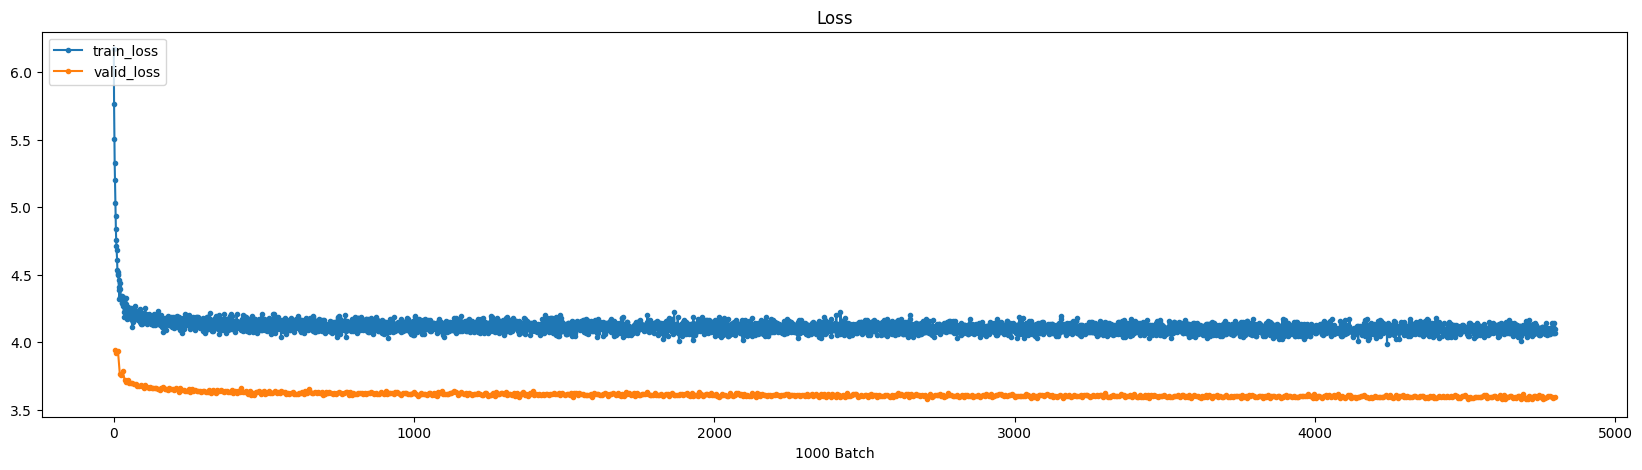

In [73]:
# loss graph
fig = plt.figure(figsize=(45, 5))
ax1 = fig.add_subplot(1, 2, 1)

train_loss_x_axis: List[int] = np.arange(len(train_loss_list)).tolist()
valid_loss_x_axis: List[int] = np.arange(start=len(train_loss_list)-1, stop=-1, step=(len(train_loss_list)/len(valid_loss_list))*-1, dtype=np.float32).astype(np.int32).tolist()[::-1]

ax1.set_title('Loss')
ax1.plot(train_loss_x_axis, train_loss_list, marker='.')
ax1.plot(valid_loss_x_axis, valid_loss_list, marker='.')
ax1.legend(['train_loss', 'valid_loss'], loc='upper left')
ax1.set_xlabel('1000 Batch')
plt.show()

In [101]:
torch.save(model, f"./models/cnn-lstm-currinfo-bs[{BATCH_SIZE}]-lr[{LEARNING_RATE}].pt")

## Testing

In [90]:
class TimeSeriesDataset(Dataset):
    def __init__(self, raw_df: pd.DataFrame, window_size: int) -> None:
        super().__init__()
        self.data: pd.DataFrame = raw_df.copy()
        self.window_size: int = window_size
        self.stock_dfs: Dict[int, pd.DataFrame]
        self.idx_map: Dict[int, Dict[str, int]]
        self.stock_dfs, self.idx_map = TimeSeriesDataset._SplitStockDataFrame(raw_df=self.data, window_size=self.window_size)
    

    def __getitem__(self, _index: int) -> Tuple[np.ndarray, np.ndarray, int, int, int]:
        '''
        return x, y, date_id, seconds_in_buckets, stock_id
        '''
        index: int = _index
        stock: int = self.idx_map[index]['stock']
        stock_idx: int = self.idx_map[index]['idx']

        start_idx, end_idx = stock_idx - (self.window_size - 1), stock_idx + 1
        return TimeSeriesDataset._GenTimeSeriesData(raw_df=self.stock_dfs[stock].iloc[start_idx:end_idx])


    def __len__(self) -> int:
        return len(self.idx_map)
    
    def FillTarget(self, stock: int, date: int, second: int, value: np.float32) -> None:
        if stock not in self.stock_dfs:
            return
        self.stock_dfs[stock].loc[(self.stock_dfs[stock]['date_id'] == date) & (self.stock_dfs[stock]['seconds_in_bucket'] == second), 'pred_target'] = value
    
    @staticmethod
    def _GenTimeSeriesData(raw_df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, int, int, int]:
        '''
        raw_df: The rows of time t-n ~ t for predicting the target of t.
        The generated features contains the data of time t-n ~ t-1.
        return x, y, date_id, seconds_in_buckets, stock_id
        '''
        df = raw_df.copy()
        df = df.sort_values(by=['date_id', 'seconds_in_bucket'], ascending=True)

        date: int = df['date_id'].tolist()[-1]
        second: int = df['seconds_in_bucket'].tolist()[-1]
        stock: int = df['stock_id'].tolist()[-1]
        y: np.float32 = df['target'].tolist()[-1]

        pred_target_not_null_indices = df['pred_target'].notnull()
        df.loc[pred_target_not_null_indices, 'target'] = df.loc[pred_target_not_null_indices, 'pred_target']
        
        df = df[MODEL_INPUT_FEATURES]
        df_numpy: np.ndarray = df.to_numpy()
        df_numpy[-1, MODEL_INPUT_FEATURES.index('target')] = 0
        
        x: np.ndarray = df_numpy
        
        return x.astype(np.float32), np.array(y).astype(np.float32), date, second, stock
    
    @staticmethod
    def _SplitStockDataFrame(raw_df: pd.DataFrame, window_size: int) -> Tuple[Dict[int, pd.DataFrame], Dict[int, Dict[str, int]]]:
        stock_dfs: Dict[int, pd.DataFrame] = {}
        idx_map: Dict[int, Dict[str, int]] = {}

        data: pd.DataFrame = raw_df.copy()
        data = data.sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id'], ascending=True)
        data.reset_index(drop=True, inplace=True)
        data_idx_offset: int = 5 * 200

        for stock in data['stock_id'].unique().tolist():
            stock_df: pd.DataFrame = data.copy().loc[data['stock_id'] == stock]
            stock_df.insert(stock_df.shape[1], 'new_idx', range(stock_df.shape[0]))
            stock_df.insert(stock_df.shape[1], 'pred_target', np.nan)
            for idx, row in stock_df.iterrows():
                if row['new_idx'] < window_size:
                    continue
                stock_idx_map: Dict[str, int] = {'stock': stock, 'idx': row['new_idx']}
                idx_map[int(idx) - data_idx_offset] = stock_idx_map
            stock_df.reset_index(drop=True, inplace=True)
            stock_df.drop('new_idx', axis=1, inplace=True)
            stock_dfs[stock] = stock_df

        return stock_dfs, idx_map

In [107]:
test_dataset: TimeSeriesDataset = TimeSeriesDataset(raw_df=test_pp_df, window_size=5)

In [108]:
print(test_dataset[2])

(array([[1.27902161e-02, 1.00000000e+00, 1.00025702e+00, 2.58485079e-02,
        1.00061798e+00, 1.00046301e+00, 1.00000000e+00, 6.23286585e-04,
        1.00036001e+00, 2.23703962e-02, 1.00000405e+00, 4.34994698e+00],
       [1.22782132e-02, 1.00000000e+00, 1.00030899e+00, 2.58485079e-02,
        1.00061798e+00, 1.00041199e+00, 1.00005102e+00, 6.18986692e-03,
        1.00036001e+00, 2.99927648e-02, 1.00006902e+00, 3.99947166e+00],
       [2.07656398e-02, 1.00000000e+00, 1.00000000e+00, 2.59973742e-02,
        1.00061798e+00, 1.00020599e+00, 9.99639988e-01, 1.81533874e-03,
        1.00010300e+00, 1.64251924e-02, 9.99655008e-01, 1.28901005e+01],
       [0.00000000e+00, 0.00000000e+00, 1.00046301e+00, 2.61507817e-02,
        1.00046301e+00, 1.00046301e+00, 1.00015402e+00, 1.25529366e-02,
        1.00051498e+00, 2.33828556e-02, 1.00020194e+00, 4.58955765e+00],
       [3.03656887e-02, 1.00000000e+00, 1.00058401e+00, 9.85518750e-03,
        1.00000000e+00, 1.00000000e+00, 9.99917984e-01, 9.0

In [97]:
# test_dataset.FillTarget(stock=0, date=477, second=540, value=np.float32(12))
# print(test_dataset[0])

(array([[ 1.0121399e-02, -1.0000000e+00,  9.9873298e-01,  1.4999378e-01,
         9.9838299e-01,  9.9838299e-01,  9.9873298e-01,  9.5575508e-03,
         9.9890798e-01,  6.2428858e-02,  9.9881601e-01, -1.9598007e+00],
       [ 1.0121399e-02, -1.0000000e+00,  9.9873298e-01,  1.4999378e-01,
         9.9838299e-01,  9.9838299e-01,  9.9873298e-01,  1.9949861e-02,
         9.9890798e-01,  1.7002003e-01,  9.9880499e-01, -1.6599894e+00],
       [ 9.9188332e-03, -1.0000000e+00,  9.9873298e-01,  1.5011580e-01,
         9.9838299e-01,  9.9838299e-01,  9.9873298e-01,  1.8082341e-02,
         9.9890798e-01,  1.8907678e-01,  9.9879599e-01, -2.3007393e-01],
       [ 9.9188332e-03, -1.0000000e+00,  9.9873298e-01,  1.5011580e-01,
         9.9838299e-01,  9.9838299e-01,  9.9873298e-01,  2.3210764e-02,
         9.9890798e-01,  3.3625606e-01,  9.9878401e-01,  1.5103817e+00],
       [ 2.9611750e-02, -1.0000000e+00,  9.9899602e-01,  1.3825254e-01,
         9.9838299e-01,  9.9838299e-01,  9.9890798e-01,  1.

In [95]:
def test(
    model, test_set: TimeSeriesDataset
) -> pd.DataFrame:
    
    result: pd.DataFrame = pd.DataFrame(columns=['date_id', 'seconds_in_bucket', 'stock_id', 'time_id', 'row_id', 'target'])

    model.eval()
    with torch.no_grad():
        with tqdm(total=len(test_set)) as pbar:
            pbar.set_description(f"Testing")
            for iter in range(len(test_set)):
                batch_x, batch_y, date, second, stock = test_set[iter]

                batch_x = torch.from_numpy(batch_x[np.newaxis, :]).to(device)
                batch_y = torch.from_numpy(batch_y).to(device)
                
                pred_y = model(batch_x).cpu().detach().numpy()

                for idx in range(len(pred_y)):
                    test_set.FillTarget(stock=stock, date=date, second=second, value=pred_y[idx])
                    curr_result: pd.DataFrame = pd.DataFrame.from_dict(data={
                        'date_id': [date], 
                        'seconds_in_bucket': [second], 
                        'stock_id': [stock], 
                        'time_id': [int(26290 + (date - 478) * 55 + second)], 
                        'row_id': [f'{date}_{second}_{stock}'], 
                        'target': [pred_y[idx][0]]
                    })
                    if result.shape[0] > 0:
                        result = pd.concat([result, curr_result], ignore_index=True)
                    else:
                        result = curr_result
                pbar.update(1)
        
    return result

In [109]:
test_result = test(model=model, test_set=test_dataset)

Testing: 100%|██████████| 33000/33000 [01:25<00:00, 387.07it/s]


In [110]:
test_result

,date_id,seconds_in_bucket,stock_id,time_id,row_id,target
0,478,0,0,26290,478_0_0,-0.169664
1,478,0,1,26290,478_0_1,-2.537034
2,478,0,2,26290,478_0_2,2.517469
3,478,0,3,26290,478_0_3,3.657625
4,478,0,4,26290,478_0_4,-0.749470
...,...,...,...,...,...,...
32995,480,540,195,26940,480_540_195,1.279591
32996,480,540,196,26940,480_540_196,0.200164
32997,480,540,197,26940,480_540_197,1.612261
32998,480,540,198,26940,480_540_198,1.571256


In [111]:
test_out_result = test_result.sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id'], ascending=True)
test_out_result.drop(['date_id', 'seconds_in_bucket', 'stock_id'], axis=1, inplace=True)
test_out_result.to_csv('./submission.csv', index=False)